In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.style import use
use('seaborn')

from calculo.canonicalVectors import positiveX, negativeX
from calculo.video import centroid


def center_of_square(contour):
    return centroid(*cv2.boundingRect(contour))


def image_proccess(frame):
    kernel = np.ones((5,5),np.uint8)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    dilation = cv2.dilate(gray, kernel, iterations=1)
    binary = cv2.threshold(dilation, 240., 255., cv2.THRESH_BINARY)[1]
    contours= cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    mark = np.array(map(center_of_square, contours))
    return mark.shape[0], mark


def roi_center(array, amp=1.4):
    y1 = array[0][1]
    y2 = array[-1][1]
    dy = (y1 - y2)*amp
    center = (y1 + y2) / 2
    return(center - dy, center +  dy)  # límite superior, límite inferior


def grouping(markers, n_expected, kroi=False):
    if kroi:
        Y = markers[:, 1]
        G0 = markers[Y < kroi[0]]
        G1 = markers[np.logical_and(Y > kroi[0], Y < kroi[1])]
        G2 = markers[Y > kroi[1]]
    else:
        G0 = markers[5:, :]
        G1 = markers[3:5, :]
        G2 = markers[:3, :]
    n_obtained = (G0.shape[0], G1.shape[0], G2.shape[0])
    boolean_interpolate = [a != b for a, b in zip(n_expected, n_obtained)]
    return(boolean_interpolate, (G0, G1, G2))


def diff(array, dt=1):
    vel = []
    for prev, new in zip(array[:-1], array[1:]):
        if prev and new:
            vel.append((new - prev) / dt)
        else:
            vel.append(None)
    vel.append(dt)  # este ultimo es arbitrario, pero no puede ser 0 o None
    return vel


def get_direction(foot_group):
    x_antepie = foot_group[0, 0]
    x_talon = foot_group[1, 0]
    if x_talon < x_antepie:
        return 1
    else:
        return -1


def sort_foot_markers(foot, direction=False):
    if foot.shape[0] != 3 and direction:
        return None
    x1, x2, refer = foot[:, 0]
    if direction:
        if direction > 0:
            if x1 < x2:
                talon = foot[0]
                antepie = foot[1]
            else:
                talon = foot[1]
                antepie = foot[0]
        elif direction < 0:
            if x1 < x2:
                talon = foot[1]
                antepie = foot[0]
            else:
                talon = foot[0]
                antepie = foot[1]
    else:
        values = ((abs(refer - x1), 0),
                  (abs(refer - x2), 1))
        talon = foot[min(values)[1]]
        antepie = foot[max(values)[1]]            
    maleolo = foot[-1]
    return np.array((antepie, talon, maleolo))


def set_direction(foot_markers, M=3):
    Y = map(lambda m: m[0][1] if  (isinstance(m, np.ndarray) and m.shape[0] != 0) else np.random.randint(0, 1000), foot_markers)
    vel = diff(Y)
    direction = 0
    for v , arr in zip(vel, foot_markers):
        if v == 0 and arr.shape[0] == M:
            sorted_foot = sort_foot_markers(arr)
            direction += get_direction(sorted_foot)
    return 1 if direction > 0 else -1


def linear(x, x1, x2, y1, y2):
    num = (x - x1)*(y2 - y1)
    div = (x2 - x1)
    if not div.all():
        return (y2 + y1) / 2
    return num / div + y1


def interpolate(A, B, n_steps):
    n_steps += 1
    x1, y1 = A.T
    x2, y2 = B.T
    dx = np.round((x2 - x1) / float(n_steps))
    interpolated = []
    for n in xrange(1, n_steps):
        X = x1 + dx*n
        Y = linear(X, x1, x2, y1, y2)
        interpolated.append(np.array((X, Y), dtype=int).T)
    return interpolated



def interval(index_to_interpolate):
    if not index_to_interpolate:
        return
    index = [x for x in index_to_interpolate]
    Xi = index.pop(0)
    if not index:
        yield Xi-1, Xi+1
        return
    it = []
    it.append(Xi)
    for i, Xj in enumerate(index):
        
        if (Xj - Xi) > 1:
            yield it[0] - 1, it[-1] + 1
            it = [Xj]
        else:
            it.append(Xj)
        Xi = Xj
    yield it[0] - 1, Xj + 1



def homogenize(binary, iterations=5):
    kernel = 1
    for __ in xrange(iterations):
        for i, value in enumerate(binary):
            binary[i] += kernel + 1
            kernel = value
        for i, value in enumerate(binary):
            if value == 1:
                binary[i] = 0
    for i, value in enumerate(binary):
        if value == 0:
            for j in xrange(1, iterations + 1):
                binary[i - j] = 0
        else:
            binary[i] = 1

            
def mov_validation(foot_movement, cycle):
    u"""Validar velocidad armónica en los marcadores de pie."""
    validate = 0
    for movement in foot_movement:
        movcopy = movement[cycle[0][0]: cycle[1][1]+1]
        temp = movcopy.pop(movcopy.index(max(movcopy)))
        level = temp * 0.5  # DEBUG(HARDCORE): se setea un nivel alto.
        for j in xrange(10):
            M = movcopy.pop(movcopy.index(max(movcopy)))
            if (temp - M) < level:
                if j == 0:
                    validate += 1
                break
            temp = M
    if validate == 2:
        return True, cycle
    else:
        return False, None


def Angle(A, B):
    """Calcula el ángulo(theta) entre dos arreglos de vectores(fila) según la
        definición de producto escalar:
            u·v = |u||v|cos(theta)
    Args:
        A: arreglo ``np.array`` de vectores fila con las posiciones x, y
            respectivamente de un punto en el plano.
        B: lo mismo que A
    Returns:
        arreglo ``np.array`` de ángulos en grados.
    """
    NA = np.linalg.norm(A, axis=1)
    NB = np.linalg.norm(B, axis=1)
    AB = A.dot(B.T).diagonal()
    radians = np.arccos(AB / (NA * NB))
    return np.degrees(radians)


def fourierfit(array, sample=101, amplitud=4):
    u"""Devuelve una aproximación de fourier con espectro que se
    define en ``amplitud``. Por defecto la muestra es de 101
    valores, sin importar el tamaño de ``array``
    """
    scale = sample/float(array.shape[1])
    fdt = np.fft.rfft(array)
    fourier_fit = np.fft.irfft(fdt[:, :amplitud], n=sample)*scale
    return fourier_fit


def convert_px_cm(cmreference, pxdistance, cmscale=30):
    u"""."""
    return pxdistance * cmscale / cmreference


def metric_reference(metrics):
    u"""."""
    if not metrics.any():
        raise Exception('NO HAY METRICASSSS')  # corregir esto
    distances = []
    X = np.sort(metrics[:, 0])
    for P0, P1 in zip(X[:-1], X[1:]):
        distances.append(abs(P0 - P1))
    return np.mean(distances)

In [2]:
class Trayectoria(object):
    u"""."""

    
    def __init__(self):
        u"""."""
        self._start = None
        self._end = None
        self._fps = None
        self._fixed = False
        self._cycled = False
        self._frames = {0:[], 1:[], 2:[], 'index_order': []}
        self._to_interpolate = {0:[], 1:[], 2:[]}
        self._joints = {}

    @property
    def start_frame(self):
        return self._start

    @start_frame.setter
    def start_frame(self, index):
        if self._start is None:
            self._start = index

    @property
    def end_frame(self):
        return self._end

    @end_frame.setter
    def end_frame(self, index):
        if self._end is None:
            self._end = index
            self.num_frames = (index - self._start) + 1

    def add_frame(self, index, groups):
        u"""."""
        for i, g in zip((0, 1, 2), groups):
            self._frames[i].append(g)
        self._frames['index_order'].append(index)

    def add_to_interpolate(self, index, bgroups):
        u"""."""
        for i, bg in zip((0, 1, 2), bgroups):
            self._to_interpolate[i].append((index, bg))

    def rm_lastNframes(self, n):
        u"""."""
        for __ in xrange(n):
            self._frames[0].pop()
            self._frames[1].pop()
            self._frames[2].pop()
            self._frames['index_order'].pop()
            self._to_interpolate[0].pop()
            self._to_interpolate[1].pop()
            self._to_interpolate[2].pop()

    def fix_in(self):
        if self._fixed:
            return
        self._direction = set_direction(self._frames[2])
        self._frames[2] = [sort_foot_markers(X, self._direction) for X in self._frames[2]]
        for group in (0, 1, 2):
            indexes = self._to_interpolate[group]
            if indexes:
                for ai, bi in interval([i for i, b in indexes if b is True]):
                    ai -= self.start_frame
                    bi -= self.start_frame
                    dt = (bi - ai) - 1
                    A = self._frames[group][ai]
                    B = self._frames[group][bi]
                    for j, arr in zip(xrange(ai + 1, bi), interpolate(A, B, dt)):
                        self._frames[group][j] = arr
        self._fixed = True

    def cycle_definition(self, fps, level=0.1):
        u"""."""
        # primer proceso. Se detecta la situacion de apoyo y balanceo
        vel = []
        lmov = []
        for i in (0, 1):
            mov = diff([X[i][1] for X in self._frames[2]], 1/fps)
            vel.append(mov)
            lmov.append(mov)
            limit = max(vel[i]) * level  # DEBUG(HARDCORE): umbral de velocidad aceptado.
            vel[i] = [abs(x) > limit for x in vel[i]]
            homogenize(vel[i])
        phases = [not (x + y) < 2 for x, y in zip(vel[0], vel[1])]

        # segundo proceso. Se detectan ciclos dentro del trayecto.
        st = []  # stance 
        cycles = []
        for i, (prev, nextt) in enumerate(zip(phases[:-1], phases[1:])):
            if prev and not nextt:  # (prev:balanceo/nextt:apoyo)
                st.append(i+1)
            if nextt and not prev: # (prev:apoyo/nextt:balanceo)
                tf = i+1  # toeoff
            if len(st) == 2:
                ret, cycle = mov_validation(lmov, ((st[0], tf-1), (tf, st[1]-1)))
                if ret:
                    cycles.append(cycle)
                st = [st[-1]]
        self._footmov = lmov
        self._phases = phases
        self._cycles = cycles
        self._cycled = True

    def get_joints(self):
        u"""."""
        for i, cycle in enumerate(self._cycles):
            (ihs, ho),(to, ehs) = cycle
            markers = {}
            codenames = (('c', 'fs'), ('ts', 'fi'), ('pa', 'pp', 'ti'))
            for j in (0, 1, 2):
                group = np.array(self._frames[j])
                for k, name in enumerate(codenames[j]):
                    markers[name] = group[ihs: ehs+1, k, :]
            # El marcador de tronco no se está utilizando.
            tight = markers['fi'] - markers['fs']
            leg = markers['ti'] - markers['ts']
            foot = markers['pa'] - markers['pp']
            
            xdirection = (None, positiveX, negativeX)[self._direction]
            hip = 90 - Angle(tight, xdirection(tight.shape[0]))
            knee = hip + (Angle(leg, xdirection(leg.shape[0])) - 90)
            ankle = 90 - Angle(leg, foot)
            hip, knee, ankle = fourierfit(np.array((hip, knee, ankle)))
            self._joints[i] = {'hip': hip, 'knee': knee, 'ankle': ankle}

In [3]:
class Kinematic(object):
    
    def __init__(self, name, fps, cmreference, trayectories):
        u"""."""
        self.name = name
        self._fps = fps
        self._cmref = cmreference
        self._trayectories = trayectories
        self._lat = (None, 'right', 'left')
        self.joints = {'right': {'hip': [], 'knee': [], 'ankle': []},
                       'left': {'hip': [], 'knee': [], 'ankle': []}}
        self.long_stride = {'right': [], 'left': []}
        self.tmcycles = {'right': [], 'left': []}
        self._split_joints()
        self._get_distances()

    def __repr__(self):
        classname = self.__class__.__name__
        videoname = self.name
        nrights = len(self.joints['right']['hip'])
        nlefts = len(self.joints['left']['hip'])
        return '%r: %s (right: %d, left: %d)' % (classname, videoname, nrights, nlefts)

    def get_joint(self, joint, lat, summary=True):
        u"""."""
        array = np.array(self.joints[lat][joint])
        n = array.shape[0]
        if summary:
            array = np.array((array.mean(axis=0), array.std(axis=0)))
        return array, n

    def _split_joints(self):
        u"""."""
        for t in self._trayectories:
            t.fix_in()
            t.cycle_definition(self._fps)
            t.get_joints()
            if t._cycles:
                for i in xrange(len(t._cycles)):
                    self.joints[self._lat[t._direction]]['hip'].append(t._joints[i]['hip'])
                    self.joints[self._lat[t._direction]]['knee'].append(t._joints[i]['knee'])
                    self.joints[self._lat[t._direction]]['ankle'].append(t._joints[i]['ankle'])

    def _get_distances(self):
        for t in self._trayectories:
            if t._cycles:
                for (s, __), (__, e) in t._cycles:
                    X0 = t._frames[2][s][1]
                    X1 = t._frames[2][e+1][1]
                    self.long_stride[self._lat[t._direction]].append(
                        convert_px_cm(self._cmref, np.linalg.norm(X0 - X1))
                    )
                    self.tmcycles[self._lat[t._direction]].append((e + 1 -s) / fps)

In [4]:
# %%time
# En este bloque se abre el video y se procesan las imágenes en busqueda de los
# marcadores.
# Solo se agregan al arreglo de datos(list) los arreglos de marcadores que se 
# delimitan en un intervalo cerrado cuyos extremos(arreglo de marcadores tambien)
# poseen 7 marcadores.

# path = '/home/mariano/Descargas/VID_20170720_132629833.mp4'  # Belen
# path = '/home/mariano/Descargas/VID_20170720_133000367.mp4'  # Belen corriendo
# path = '/home/mariano/Descargas/VID_20170728_112226772.mp4'  # Maxi Hissa
# path = '/home/mariano/Descargas/VID_20170831_093451442.mp4'  # Ferrando
path = '/home/mariano/Descargas/VID_20170831_095319235.mp4'

vid = cv2.VideoCapture(path)
fps = vid.get(cv2.CAP_PROP_FPS)
is_frame, frame = vid.read()
expected_markers = (2, 2, 3)
M = sum(expected_markers)
safe_None = 1.5 * fps
last_M = 0
active = False
count_non_data = 0
trayectories = []
i = 0

n_metrics = 5
metrics = np.zeros((1, 1))

t = Trayectoria()
while is_frame:
    m, mark = image_proccess(frame)
    if mark.any():
        if m == M:
            active = True
            t.start_frame = i
            last_M = i
            count_non_data = 0
############################################################################################################
# Se adiciona código para obtener metricas.
# Esta parte del codigo es peligrosa.. debe hacerce notar la importancia de inciar con metricas cada video.
        if not metrics.any() and not active:
            if m == n_metrics:
                metrics = mark
############################################################################################################
        if active:
            if m != M:
                to_interp, groups = grouping(mark, expected_markers, kr)
                t.add_frame(i, groups)
                t.add_to_interpolate(i, to_interp)
            else:
                __, groups = grouping(mark, expected_markers)
                kr = roi_center(groups[1])
                t.add_frame(i, groups)
    else:
        count_non_data += 1
        if active and count_non_data < safe_None:
            G0 = np.random.randint(0, 100, (2, 2))
            G1 = np.random.randint(0, 100, (2, 2))
            G2 = np.random.randint(0, 100, (3, 2))
            t.add_frame(i, (G0, G1, G0))
            t.add_to_interpolate(i, (True, True, True))
        else:
            if active:
                backwards = (i - 1) - last_M
                t.rm_lastNframes(backwards)
                t.end_frame = i - backwards - 1
                trayectories.append(t)
                t = Trayectoria()
                active = False
    is_frame, frame = vid.read()
    i += 1

In [5]:
ref = metric_reference(metrics)
K = Kinematic(path, fps, ref, trayectories)
K

'Kinematic': /home/mariano/Descargas/VID_20170831_095319235.mp4 (right: 14, left: 16)

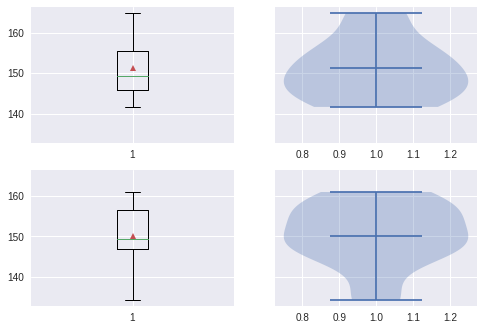

In [6]:
fig, ((a11, a12),(a21, a22)) = plt.subplots(nrows=2, ncols=2, sharey=True)
a11.boxplot(K.long_stride['right'], showmeans=True)
a12.violinplot(K.long_stride['right'], showmeans=True)
a21.boxplot(K.long_stride['left'], showmeans=True)
a22.violinplot(K.long_stride['left'], showmeans=True)
plt.show()


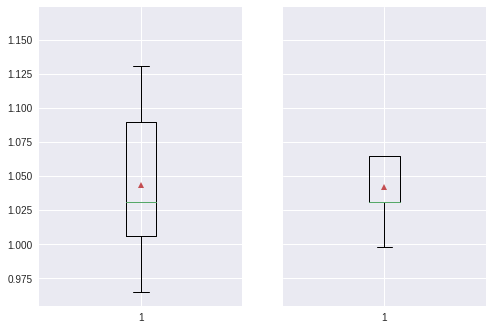

In [7]:
fig, (a11, a12) = plt.subplots(nrows=1, ncols=2, sharey=True)
a11.boxplot(K.tmcycles['right'], showmeans=True)
a12.boxplot(K.tmcycles['left'], showmeans=True)
plt.show()

In [8]:
t = trayectories[1]
(s, __), (__, e) = t._cycles[0]
cyc = range(t._start + s, t._start + e + 1)

from time import sleep

vid = cv2.VideoCapture(path)
n = 0
i = 0
j = 0
font = cv2.FONT_HERSHEY_TRIPLEX
while True:
    is_frame, frame = vid.read()
    wait = 0
    if is_frame is False:
        break
    if n >= t._start and n <= t._end:
        wait = .15
        color = (0, 255, 255)
        arr = t._frames[0][i]
        kn = t._frames[1][i][0]
        hp = t._frames[0][i][0]
        ak = t._frames[2][i][0]
        if n in cyc:
            color = (0, 0, 255)
            thp = str(round(t._joints.values()[0]['hip'][j], 2))
            tkn = str(round(t._joints.values()[0]['knee'][j], 2))
            tak = str(round(t._joints.values()[0]['ankle'][j], 2))
            cv2.putText(frame, thp, (hp[0], hp[1]), font, 1.2, color)
            cv2.putText(frame, tkn, (kn[0], kn[1]), font, 1.2, color)
            cv2.putText(frame, tak, (ak[0], ak[1]), font, 1.2, color)
            j += 1
        for m in arr: 
            cv2.circle(frame, (m[0], m[1]), 7, color, -1)
        i += 1
    cv2.imshow(path, cv2.resize(frame, None, fx=.4, fy=.4))
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    n += 1
    sleep(wait)
vid.release()
cv2.destroyAllWindows()


In [9]:
# # Este codigo se me ocurre como opción para debuguear.
# for t in trayectories:
#     print t._direction
#     t.cycle_definition(fps,.13)
#     plt.plot(t._footmov[0])
#     plt.plot(t._footmov[1])
#     plt.plot(np.array(t._phases)*1000)
#     plt.show()

In [10]:
# posible codigo para saber la cantidad de cuadros interpolados por ciclo por grupo
# for t in trayectories:
#     for c in t._cycles:
#         (s, __), (__, e) = t._cycles[c]
#         cyc = range(t._start + s, t._start + e + 1)
#         for i in (0, 1, 2):
#             inter = zip(t._to_interpolate['index_order'], t._to_interpolate[i])
#             cc = sum([True for z in ciclo if z in [x for x, y in inter if y]])
#             print cc